<a href="https://colab.research.google.com/github/jiyingz/COVID19_projections/blob/master/india_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Modeling the Coronavirus in India**
This is an implementation of an SELICRD model:

*   S = Susceptible
*   E = Exposed
*   L = Latent
*   I = Infected
*   C = Critical
*   R = Recovered
*   D = Death


---
Following Henri Froese: https://towardsdatascience.com/infectious-disease-modelling-fit-your-model-to-coronavirus-data-2568e672dbc7






# Imports

In [2]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline 
!pip install mpld3
import mpld3
mpld3.enable_notebook()

from scipy.integrate import odeint
!pip install lmfit
import lmfit
from lmfit.lineshapes import gaussian, lorentzian

import warnings
warnings.filterwarnings('ignore')

     |████████████████████████████████| 798kB 2.8MB/s 
  Created wheel for mpld3: filename=mpld3-0.3-cp36-none-any.whl size=116679 sha256=d2329ee6ff765d47294d1f2401f2bebdee935697cbdbbe2d0f6b265230a27870
  Stored in directory: /root/.cache/pip/wheels/c0/47/fb/8a64f89aecfe0059830479308ad42d62e898a3e3cefdf6ba28
Successfully built mpld3
     |████████████████████████████████| 266kB 2.7MB/s 
     |████████████████████████████████| 61kB 8.3MB/s 
     |████████████████████████████████| 235kB 35.3MB/s 
  Created wheel for lmfit: filename=lmfit-1.0.1-cp36-none-any.whl size=81990 sha256=95c1c7dc25b78d9357b7490f543bfee67cbd805714c18212c0e92fad9f30f157
  Stored in directory: /root/.cache/pip/wheels/ef/22/8d/6cd9c0af36f501cfb248673b05dad5d2c27504951d55519acb
  Created wheel for asteval: filename=asteval-0.9.18-cp36-none-any.whl size=17381 sha256=6c2b20e3eb7749391c88fe554d8bc3477789e1ba7aebdc50c279c23155a2edb8
  Stored in directory: /root/.cache/pip/wheels/1c/53/1b/28d929700c9633b1786a4982e6db564ec8

# Supplemental and Coronavirus Data

In [0]:
# read the data - TO DO -- find more accurate bed data for India
beds = pd.read_csv("https://raw.githubusercontent.com/hf2000510/infectious_disease_modelling/master/data/beds.csv", header=0)
agegroups = pd.read_csv("https://raw.githubusercontent.com/hf2000510/infectious_disease_modelling/master/data/agegroups.csv")
covid_data = pd.read_csv("https://tinyurl.com/t59cgxn", parse_dates=["Date"], skiprows=[1])
covid_data["Location"] = covid_data["Country/Region"]

# create some dicts for fast lookup
# 1. beds
beds_lookup = dict(zip(beds["Country"], beds["ICU_Beds"]))
# 2. agegroups
agegroup_lookup = dict(zip(agegroups['Location'], agegroups[['0_9', '10_19', '20_29', '30_39', '40_49', '50_59', '60_69', '70_79', '80_89', '90_100']].values))

# Setting Hyperparameters


In [0]:
# setting hyperparameters 
gamma = 1.0 / 14 #  days from infection to recovery
delta = 1.0 / 5  # incubation period 
epsilon = 1.0 / 14 # recovery for latent person
theta = 1.0 / 2 # days from latency to showing symptoms
lamda = 1.0 / 11 # infected to  critical
tau = 1.0 / 11.5 # time for critical patients to recover
rho = 1.0 / 7.5 # days from critical to death
sigma = theta

## Plotting

In [5]:
plt.gcf().subplots_adjust(bottom=0.15)

def plotter(t, S, E, L, I, C, R, D, R_0, B, S_1=None, S_2=None, x_ticks=None):
    if S_1 is not None and S_2 is not None:
      print(f"percentage going to ICU: {S_1*100}; percentage dying in ICU: {S_2 * 100}")


    f, ax = plt.subplots(1,1,figsize=(20,4))
    if x_ticks is None:
        ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(t, C, 'r--', alpha=0.7, linewidth=2, label='Critical')
        ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
        ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
    else:
        ax.plot(x_ticks, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.plot(x_ticks, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.plot(x_ticks, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(x_ticks, C, 'r--', alpha=0.7, linewidth=2, label='Critical')
        ax.plot(x_ticks, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
        ax.plot(x_ticks, D, 'k', alpha=0.7, linewidth=2, label='Dead')

        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()


    ax.title.set_text('extended SEIR-Model')

    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    plt.show();
    
    f = plt.figure(figsize=(20,4))
    # sp1
    ax1 = f.add_subplot(131)
    if x_ticks is None:
        ax1.plot(t, R_0, 'b--', alpha=0.7, linewidth=2, label='R_0')
    else:
        ax1.plot(x_ticks, R_0, 'b--', alpha=0.7, linewidth=2, label='R_0')
        ax1.xaxis.set_major_locator(mdates.YearLocator())
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax1.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()

 
    ax1.title.set_text('R_0 over time')
    ax1.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax1.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    
    # sp2
    ax2 = f.add_subplot(132)
    total_CFR = [0] + [100 * D[i] / sum(sigma*E[:i]) if sum(sigma*E[:i])>0 else 0 for i in range(1, len(t))]
    daily_CFR = [0] + [100 * ((D[i]-D[i-1]) / ((R[i]-R[i-1]) + (D[i]-D[i-1]))) if max((R[i]-R[i-1]), (D[i]-D[i-1]))>10 else 0 for i in range(1, len(t))]
    if x_ticks is None:
        ax2.plot(t, total_CFR, 'r--', alpha=0.7, linewidth=2, label='total')
        ax2.plot(t, daily_CFR, 'b--', alpha=0.7, linewidth=2, label='daily')
    else:
        ax2.plot(x_ticks, total_CFR, 'r--', alpha=0.7, linewidth=2, label='total')
        ax2.plot(x_ticks, daily_CFR, 'b--', alpha=0.7, linewidth=2, label='daily')
        ax2.xaxis.set_major_locator(mdates.YearLocator())
        ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax2.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()

    ax2.title.set_text('Fatality Rate (%)')
    ax2.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax2.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    # sp3
    ax3 = f.add_subplot(133)
    newDs = [0] + [D[i]-D[i-1] for i in range(1, len(t))]
    if x_ticks is None:
        ax3.plot(t, newDs, 'r--', alpha=0.7, linewidth=2, label='total')
        ax3.plot(t, [max(0, C[i]-B(i)) for i in range(len(t))], 'b--', alpha=0.7, linewidth=2, label="over capacity")
    else:
        ax3.plot(x_ticks, newDs, 'r--', alpha=0.7, linewidth=2, label='total')
        ax3.plot(x_ticks, [max(0, C[i]-B(i)) for i in range(len(t))], 'b--', alpha=0.7, linewidth=2, label="over capacity")
        ax3.xaxis.set_major_locator(mdates.YearLocator())
        ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax3.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()

    ax3.title.set_text('Deaths per day')
    ax3.yaxis.set_tick_params(length=0)
    ax3.xaxis.set_tick_params(length=0)
    ax3.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax3.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    plt.show();

<Figure size 432x288 with 0 Axes>

# Modelling Functions

In [0]:
def deriv(y, t, N, beta, delta, epsilon, p_L_to_R, theta, gamma, p_C_to_D, p_I_to_C, lamda, tau, rho, beds):
    S, E, L, I, C, R, D = y

    dSdt = - beta(t) * S * (I + L) / N
    dEdt = beta(t) * S * (I + L) / N - delta * E
    dLdt = delta * E - epsilon * p_L_to_R * L - theta * (1 - p_L_to_R) * L
    dIdt = theta * (1 - p_L_to_R) * L - gamma * (1 - p_I_to_C) * I  - lamda * p_I_to_C * I
    dCdt = lamda * p_I_to_C * I - tau * (1 - p_C_to_D) * min(beds(t), C) - rho * p_C_to_D * min(beds(t), C) \
           - max(0, C - beds(t))
    dRdt = gamma * (1 - p_I_to_C) * I + tau * (1 - p_C_to_D) * min(beds(t), C) + epsilon * p_L_to_R * L
    dDdt = rho * p_C_to_D * min(beds(t), C) + max(0, C-beds(t))
    return dSdt, dEdt, dLdt, dIdt, dCdt, dRdt, dDdt


def logistic_R_0(t, R_0_start, k, x0, R_0_end):
    if -k*(-t+x0) >= 500: return R_0_end
    return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end


def Model(days, agegroups, beds_per_100k, R_0_start, k, x0, R_0_end, p_L_to_R, p_I_to_C, p_C_to_D, s):
    # infection rate comes from current R0
    def beta(t):
        return logistic_R_0(t, R_0_start, k, x0, R_0_end) * gamma
    # model bed usage in the poplation
    def beds(t):
        beds_0 = beds_per_100k / 100_000 * N
        return beds_0 + s*beds_0*t  # 0.003
    # run model
    N = sum(agegroups)
    y0 = N-1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0
    t = np.linspace(0, days, days)
    ret = odeint(deriv, y0, t, args=(N, beta, delta, epsilon, p_L_to_R, theta, gamma, p_C_to_D, p_I_to_C, lamda, tau, rho, beds))
    S, E, L, I, C, R, D = ret.T
    R_0_over_time = [beta(i)/gamma for i in range(len(t))]
    return t, S, E, L, I, C, R, D, R_0_over_time, beds, p_I_to_C, p_C_to_D

# Fitting

In [0]:
# set up the hyper-parameters, and gather data
data = covid_data[covid_data["Location"] == "India"]["Value"].values[::-1]
agegroups = agegroup_lookup["India"]
beds_per_100k = beds_lookup["India"]
outbreak_shift = 0
params_init_min_max = {"R_0_start": (3.0, 1.0, 5.0), "k": (2.5, 0.01, 5.0), "x0": (96, 30, 100), "R_0_end": (0.9, 0.3, 3.5), "p_L_to_R": (0.6, 0.4, 0.8),
                       "p_I_to_C": (0.05, 0.01, 0.1), "p_C_to_D": (0.5, 0.05, 0.8),
                       "s": (0.003, 0.001, 0.01)}  # form: {parameter: (initial guess, minimum value, max value)}

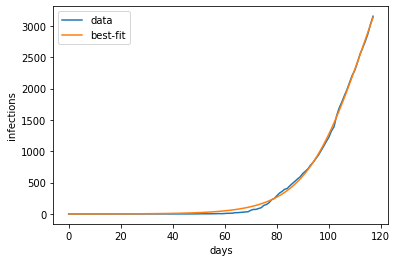

In [8]:
days = outbreak_shift + len(data)
if outbreak_shift >= 0:
    y_data = np.concatenate((np.zeros(outbreak_shift), data))
else:
    y_data = y_data[-outbreak_shift:]

x_data = np.linspace(0, days - 1, days, dtype=int)  # x_data is just [0, 1, ..., max_days] array

def fitter(x, R_0_start, k, x0, R_0_end, p_L_to_R, p_I_to_C, p_C_to_D, s):
    ret = Model(days, agegroups, beds_per_100k, R_0_start, k, x0, R_0_end, p_L_to_R, p_I_to_C, p_C_to_D, s)
    return ret[6][x]

mod = lmfit.Model(fitter)

for kwarg, (init, mini, maxi) in params_init_min_max.items():
    mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)


params = mod.make_params()
result = mod.fit(y_data, params, method="least_squares", x=x_data)
ax = plt.subplots()
result.plot_fit(datafmt="-");
plt.xlabel('days')
plt.ylabel('infections')
plt.title('')
plt.show()

In [9]:
result.best_values

{'R_0_end': 0.46368928458512326,
 'R_0_start': 2.8259353346524354,
 'k': 0.13722585513769406,
 'p_C_to_D': 0.7999995521381011,
 'p_I_to_C': 0.09999995043955284,
 'p_L_to_R': 0.40000000002085606,
 's': 0.003,
 'x0': 99.21640774200696}

Prediction for India
percentage going to ICU: 9.999995043955284; percentage dying in ICU: 79.99995521381011


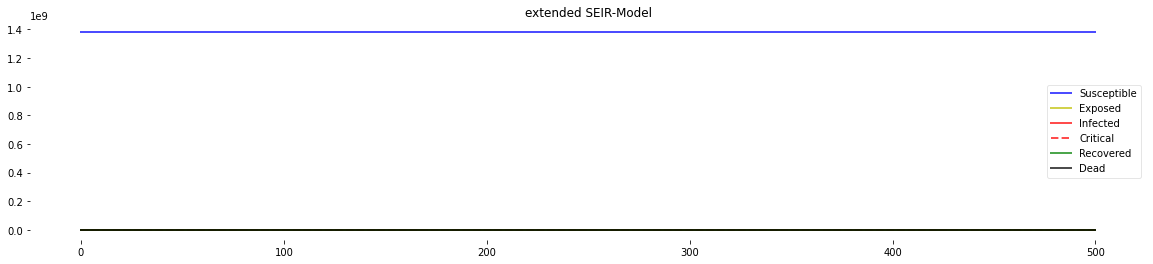

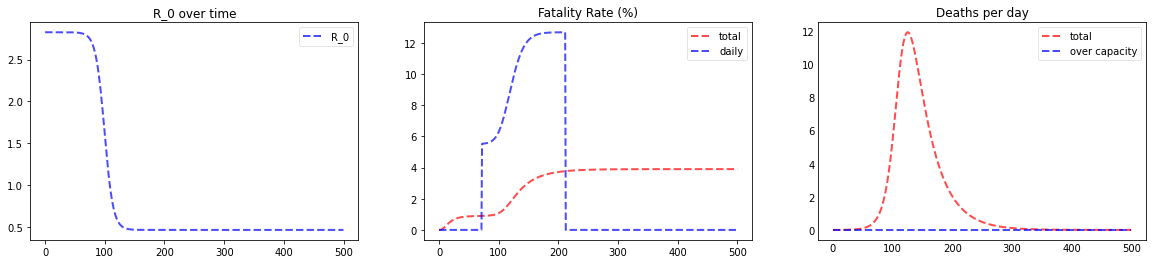

In [10]:
country = "India"
full_days = 500
first_date = np.datetime64(covid_data.Date.min()) - np.timedelta64(outbreak_shift,'D')
x_ticks = pd.date_range(start=first_date, periods=full_days, freq="D")
print("Prediction for " + country)
plotter(*Model(full_days, agegroup_lookup[country], beds_lookup[country], **result.best_values));


# Validation (Back-testing)

In [0]:
%%capture
val = np.linspace(2, days-1, days - 2)
val = val / days
train_costs = np.zeros(len(val))
test_costs = np.zeros(len(val))
training_size = np.zeros(len(val))
results = []

for i in range(len(val)):
  # Divide train and test by a timescale
  days_train = int(np.floor(val[i] * days))
  days_test = days - days_train
  
  if outbreak_shift >= 0:
    y_train = np.concatenate((np.zeros(outbreak_shift), data[0:days_train]))
  else:
    y_train = y_data[-outbreak_shift:days_train]
  y_test = data[days_train:(days-1)]
  
  x_train = np.linspace(0, days_train - 1, days_train, dtype = int)
  x_test = np.linspace(days_train, days - 1, days - days_train - 1, dtype = int)
  
  training_size[i] = len(x_train)
  
  # Run the model, and retrieve the parameters
  mod = lmfit.Model(fitter)
  for kwarg, (init, mini, maxi) in params_init_min_max.items():
    mod.set_param_hint(str(kwarg), value = init, min = mini, max = maxi, vary = True)
  
  params = mod.make_params()
  result = mod.fit(y_train, params, method = "least_squares", x = x_train)
  results.append(result)
  best_params = mod.make_params(result.best_values)
  
  train_cost = (1/days_train) * np.sum(np.square(result.residual))

  # Run predictions for test set
  predictions = result.eval(params = best_params, x = x_test)
  test_cost = (1/days_test) * np.sum(np.square(y_test - predictions))

  # save the costs
  train_costs[i] = train_cost
  test_costs[i] = test_cost



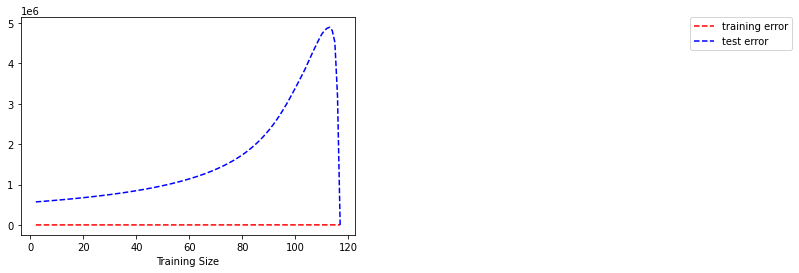

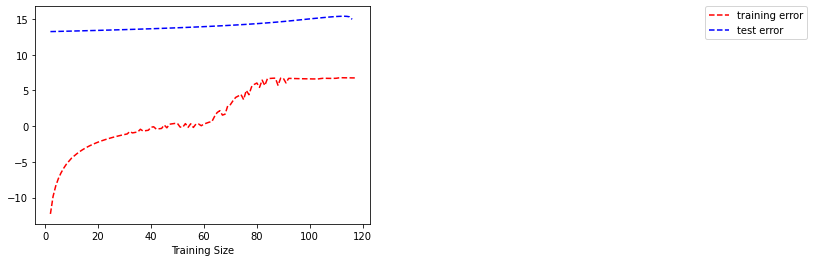

In [39]:
# Plot the errors
plt.plot(training_size, train_costs, 'r--', label = "training error")
plt.plot(training_size, test_costs, 'b--', label = "test error")
plt.legend(bbox_to_anchor=(2, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('Training Size')
plt.show()

# Plot the log errors
plt.plot(training_size, np.log(train_costs), 'r--', label = "training error")
plt.plot(training_size, np.log(test_costs), 'b--', label = "test error")
plt.legend(bbox_to_anchor=(2, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('Training Size')
plt.show()